In [1]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from auction_env import *
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from stable_baselines import TD3
from stable_baselines.common.env_checker import check_env
from stable_baselines import results_plotter
from stable_baselines.bench import Monitor
%matplotlib inline
import os

In [2]:
# Set seeds for reproducible results
#seed = 12
seed = 1234
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

## HighLowEnv

In [3]:
#List out our bandit arms. 
distribution = 'uniform'

interval_size = 0.05
no_intervals = int(1/interval_size) + 1
bandit_arms = [(i,j) for i in range(no_intervals) for j in range(i, no_intervals)]
num_arms = len(bandit_arms)

#Env parameters
env_params = {'v_high':1, 'v_low':0.3, 'p_high':0.8, 'p_low':0.1}

In [4]:
total_rounds = 50
round_size = 1000
total_episodes = total_rounds*round_size #Set total number of episodes to train agent on.

In [5]:
def draw_type():
    return np.random.uniform()
    
def pullBandit(arm, v_high=1, v_low=0.3, p_high=0.8, p_low=0.1):
    agent_type = draw_type()
    
    low_reward, high_reward = arm
    low_reward *= interval_size
    high_reward *= interval_size

    low_u = p_low*high_reward + (1-p_low)*low_reward
    high_u = p_high*high_reward + (1-p_high)*low_reward - agent_type

    if high_u >= low_u:
        outcome_prob = [1-p_high, p_high]
    else:
        outcome_prob = [1-p_low, p_low]

    outcome = str(np.random.choice(['low','high'], p=outcome_prob))

    if outcome == 'high':
        reward = v_high - high_reward
    else:
        reward = v_low - low_reward

    return reward

## MC Control

In [6]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn():
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [7]:
epsilon = 0.025
Q = [0] * num_arms
Q_calc = [[0,0] for _ in range(num_arms)] # Number of actions, cumulative reward
policy = make_epsilon_greedy_policy(Q, epsilon, num_arms)

In [8]:
best_actions = []
rewards = []
rewards_track = []

for i in range(1, total_episodes + 1):
    if i % round_size == 0:
        print("\rEpisode {}/{}.".format(i, total_episodes), end="")
        best_actions.append(np.argmax(Q))
        rewards_track.append(np.mean(rewards))
        rewards = []
            
    action_probs = policy()
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
    reward = pullBandit(bandit_arms[action], **env_params)
    rewards.append(reward)
    
    Q_calc[action][0] += 1
    Q_calc[action][1] += reward
    Q[action] = Q_calc[action][1]/Q_calc[action][0]

Episode 50000/50000.

Text(0.5, 1.0, 'Discrete Action Space, Uniform Distribution Type')

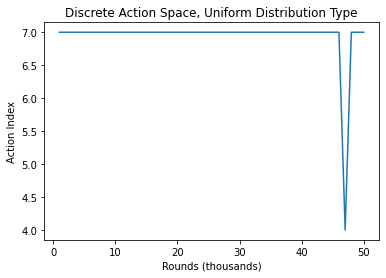

In [9]:
x_uniform = [i+1 for i in range(len(best_actions))]

plt.plot(x_uniform, best_actions)
plt.xlabel('Rounds (thousands)')
plt.ylabel('Action Index')
plt.title('Discrete Action Space, Uniform Distribution Type')

Text(0.5, 1.0, 'Discrete Action Space, Uniform Distribution Type')

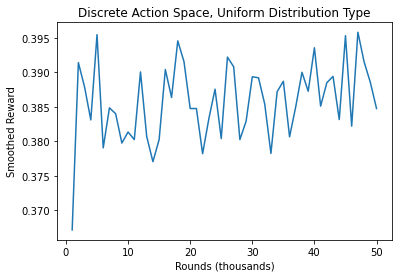

In [10]:
rewards_track_mc = rewards_track

plt.plot(x_uniform, rewards_track_mc)
plt.xlabel('Rounds (thousands)')
plt.ylabel('Smoothed Reward')
plt.title('Discrete Action Space, Uniform Distribution Type')

In [11]:
bandit_arms[best_actions[-1]]

(0, 7)

## Policy Gradients

In [12]:
tf.reset_default_graph()

#These two lines established the feed-forward part of the network. 
weights = tf.Variable(tf.ones([num_arms]))
output = tf.nn.softmax(weights)

#The next six lines establish the training proceedure. We feed the reward and chosen action into the network
#to compute the loss, and use it to update the network.
reward_holder = tf.placeholder(shape=[1],dtype=tf.float32)
action_holder = tf.placeholder(shape=[1],dtype=tf.int32)

responsible_output = tf.slice(output,action_holder,[1])
loss = -(tf.log(responsible_output)*reward_holder)


global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.005
decayed_learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 1000, 0.99, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=decayed_learning_rate)


#optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
update = optimizer.minimize(loss)

In [13]:
total_reward = np.zeros(num_arms) #Set scoreboard for bandit arms to 0.
rewards = []
best_actions_pg = [] # Store intermittent best actions
rewards_track = [] # Store intermittent rewards smoothed over past 1000 episodes

init = tf.global_variables_initializer()

# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(1, total_episodes + 1):
        if i % round_size == 0:
            print("\rEpisode {}/{}.".format(i, total_episodes), end="")
            best_actions_pg.append(np.argmax(ww))
            rewards_track.append(np.mean(rewards))
            rewards = []
            
            
        #Choose action according to Boltzmann distribution.
        actions = sess.run(output)
        action = np.random.choice(list(range(num_arms)),p=actions)

        reward = pullBandit(bandit_arms[action], **env_params) #Get our reward from picking one of the bandit arms.
        if i > round_size:
            baseline = rewards_track[-1]
        else:
            baseline = 0 # Leave baseline out for now
        #advantage = reward - baseline
        advantage = reward 
        #print(action, bandit_arms[action], reward)
        
        #Update the network.
        _,resp,ww = sess.run([update,responsible_output,weights], feed_dict={reward_holder:[advantage],action_holder:[action]})
        
        #Update our running tally of scores.
        total_reward[action] += reward
        rewards.append(reward)


Episode 50000/50000.

Text(0.5, 1.0, 'Discrete Action Space, Uniform Distribution Type')

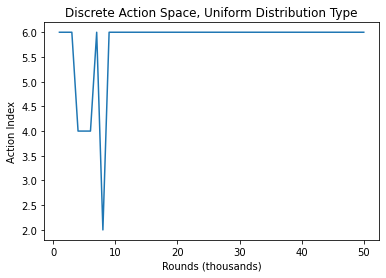

In [14]:
x_uniform_pg = [i+1 for i in range(len(best_actions_pg))]

plt.plot(x_uniform_pg, best_actions_pg)
plt.xlabel('Rounds (thousands)')
plt.ylabel('Action Index')
plt.title('Discrete Action Space, Uniform Distribution Type')

Text(0.5, 1.0, 'Discrete Action Space, Uniform Distribution Type')

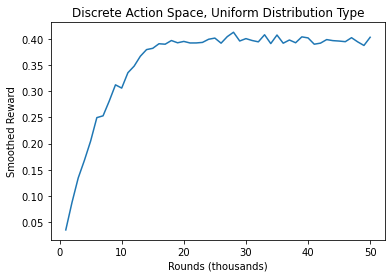

In [15]:
plt.plot(x_uniform_pg, rewards_track)
plt.xlabel('Rounds (thousands)')
plt.ylabel('Smoothed Reward')
plt.title('Discrete Action Space, Uniform Distribution Type')

## Stable Baselines

In [16]:
# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

In [17]:
def train_and_plot(algo, env, plot_title, time_steps=50000, policy='MlpPolicy', **kwargs):
    check_env(env, warn=True)
    env = Monitor(env, log_dir)
    
    model = algo(policy, env, **kwargs)
    model.learn(total_timesteps=time_steps)
    
    results_plotter.plot_results([log_dir], time_steps, results_plotter.X_TIMESTEPS, plot_title)
    plt.show()
    return model

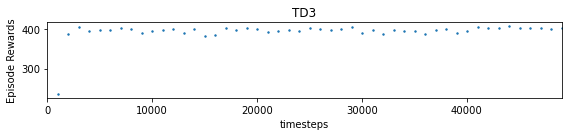

In [18]:
env = HighLowEnv(**env_params)
model = train_and_plot(TD3, env, plot_title='TD3', time_steps=total_episodes, policy='MlpPolicy', verbose = 0)

In [19]:
rewards_track_sb = list([res/1000 for res in results_plotter.load_results(log_dir)['r']])

## Compilation of Results

In [20]:
def optimal_rh(env):
    return (env.v_high-env.v_low)/2 - env.p_low/(2*(env.p_high-env.p_low)**2)

def optimal_eu(env):
    r = optimal_rh(env)
    p_diff = env.p_high-env.p_low
    profit_high = env.v_high - r
    return r*p_diff*(env.p_high*profit_high+(1-env.p_high)*env.v_low) + (1-r*p_diff)*(env.p_low*profit_high+(1-env.p_low)*env.v_low)

In [21]:
opt_u = optimal_eu(env)
opt_line = [opt_u for _ in x_uniform_pg]
x_uniform_pg = x_uniform_pg[1:]

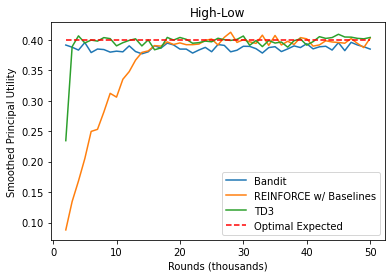

In [22]:
plt.plot(x_uniform_pg, rewards_track_mc[1:], label='Bandit')
plt.plot(x_uniform_pg, rewards_track[1:], label='REINFORCE w/ Baselines')
plt.plot(x_uniform_pg, rewards_track_sb, label='TD3')
plt.plot(x_uniform_pg, opt_line[1:], '--', color='r', label='Optimal Expected')
plt.title('High-Low')
plt.xlabel('Rounds (thousands)')
plt.ylabel('Smoothed Principal Utility')
plt.legend()